In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

In [19]:
dataset_path = "dataset/dataset-spotify-2023.csv"
data = pd.read_csv(dataset_path, encoding="latin-1")
columns = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%",
"liveness_%", "speechiness_%"]
data = data.rename(columns={column: column.replace("_%", "") for column in columns})
key_None_count = data["key"].isna().sum()
in_shazam_charts_None_count = data["in_shazam_charts"].isna().sum()

print("`key` None count: ", key_None_count)
print("`in_shazam_charts` None count: ", in_shazam_charts_None_count)

# Replace NaN values with Unspecified, it may be useful later on
data = data.replace(np.nan, "Unavailable")

# Data is malformed, need to remove comma `,`
data["in_deezer_playlists"] = data["in_deezer_playlists"].replace(",", "", regex=True)
data["in_shazam_charts"] = data["in_deezer_playlists"].replace(",", "", regex=True)

# Convert columns to int64
# streams, in_deezer_playlists, in_shazam_charts
data["in_deezer_playlists"] = data["in_deezer_playlists"].astype(int)
data["in_shazam_charts"] = data["in_shazam_charts"].astype(int)

# Streams overflowed with int, so use np.int64 to fit the whole numbers
data["streams"] = data["streams"].astype(np.int64)

# Wee see that `streams` is very large compared to to other data, next larger is `in_spotify_playlists`
# Add extra column with log value of streams
# data["streams_log"] = np.log2(data["streams"])

`key` None count:  95
`in_shazam_charts` None count:  50


In [20]:
# One-hot encoding values
data = pd.get_dummies(data, columns=["key", "mode"], prefix=["key", "mode"])
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [21]:
# Select numeric columns
data_numeric = data.select_dtypes(exclude="object")
data_numeric.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   artist_count          952 non-null    int64
 1   released_year         952 non-null    int64
 2   released_month        952 non-null    int64
 3   released_day          952 non-null    int64
 4   in_spotify_playlists  952 non-null    int64
 5   in_spotify_charts     952 non-null    int64
 6   streams               952 non-null    int64
 7   in_apple_playlists    952 non-null    int64
 8   in_apple_charts       952 non-null    int64
 9   in_deezer_playlists   952 non-null    int64
 10  in_deezer_charts      952 non-null    int64
 11  in_shazam_charts      952 non-null    int64
 12  bpm                   952 non-null    int64
 13  danceability          952 non-null    int64
 14  valence               952 non-null    int64
 15  energy                952 non-null    int64
 16  acoustic

In [22]:

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_numeric)
data_numeric = pd.DataFrame(data_normalized, columns=data_numeric.columns)

In [23]:
# Regression
# Target value is `streams`
X = torch.tensor(data_numeric.drop("streams", axis=1).values, dtype=torch.float32)
Y = torch.tensor(data_numeric["streams"].values, dtype=torch.float32).view(-1, 1)



Ridge Regression with Lambda = 1e-10:
- Training error: 0.9556618414002029
- Test error:     1.0106268291559322


Ridge Regression with Lambda = 1.592282793341094e-10:
- Training error: 0.9556618414002029
- Test error:     1.0106268291559273


Ridge Regression with Lambda = 2.5353644939701164e-10:
- Training error: 0.9556618414002029
- Test error:     1.0106268291559197


Ridge Regression with Lambda = 4.03701725859655e-10:
- Training error: 0.9556618414002029
- Test error:     1.0106268291559075


Ridge Regression with Lambda = 6.428073117284319e-10:
- Training error: 0.9556618414002029
- Test error:     1.0106268291558884


Ridge Regression with Lambda = 1.0235310218990269e-09:
- Training error: 0.9556618414002029
- Test error:     1.0106268291558576


Ridge Regression with Lambda = 1.6297508346206469e-09:
- Training error: 0.9556618414002029
- Test error:     1.010626829155809


Ridge Regression with Lambda = 2.595024211399732e-09:
- Training error: 0.9556618414002029
- Test error

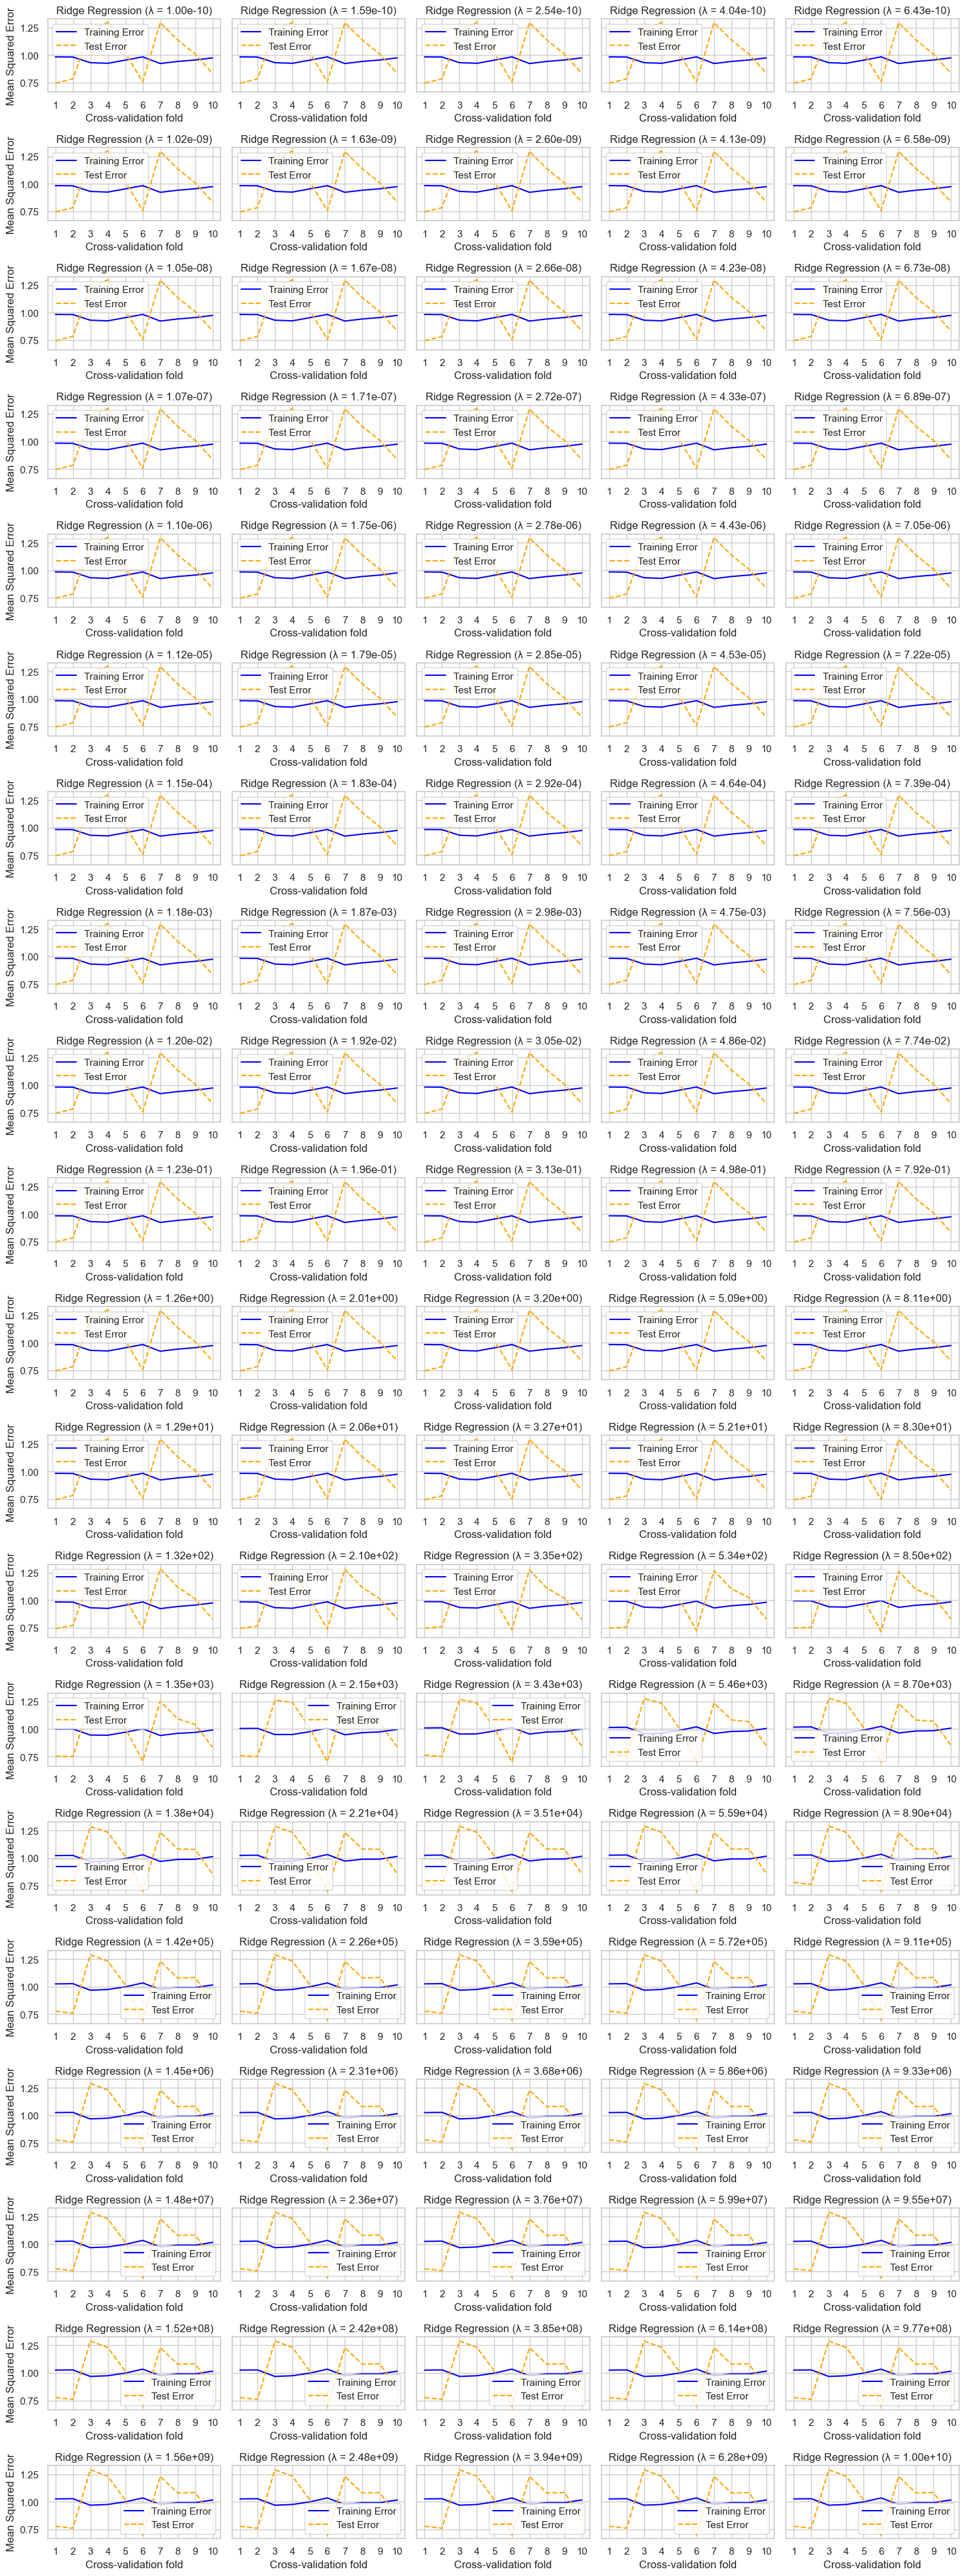

In [24]:
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import torch
import numpy as np

# Selecting features (X) and target variable (y)
composition_features = ['bpm', 'mode_Major', 'mode_Minor', 'key_A',
                        'key_A#',
                        'key_B',
                        'key_C#',
                        'key_D',
                        'key_D#',
                        'key_E',
                        'key_F',
                        'key_F#',
                        'key_G',
                        'key_G#', 'danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness',
                        'speechiness']
# musical_features = ['danceability','valence','energy','acousticness','instrumentalness','liveness','speechiness']

X = torch.tensor(
    data_numeric[composition_features].values, dtype=torch.float32)
Y = torch.tensor(data_numeric["streams"].values,
                 dtype=torch.float32).view(-1, 1)

# Crossvalidation
# Create cross-validation partition for evaluation
K = 10
CV = KFold(n_splits=K, shuffle=True, random_state=42)

# Regularization parameter values
lambda_interval = np.logspace(-10, 10, 100)

# Initialize variables
Features = np.zeros((len(composition_features), K, len(lambda_interval)))
Error_train = np.empty((K, len(lambda_interval)))
Error_test = np.empty((K, len(lambda_interval)))

k = 0
for train_index, test_index in CV.split(X):
    # extract training and test set for the current CV fold
    X_train = X[train_index, :]
    y_train = Y[train_index]
    X_test = X[test_index, :]
    y_test = Y[test_index]

    internal_cross_validation = 10

    for i, lambda_val in enumerate(lambda_interval):
        # Compute squared error with feature subset selection and Ridge regression
        # Using all features for simplicity
        selected_features = range(X_train.shape[1])
        m = Ridge(alpha=lambda_val, fit_intercept=True).fit(
            X_train[:, selected_features], y_train)
        Error_train[k, i] = np.square(
            y_train - m.predict(X_train[:, selected_features])).sum() / y_train.shape[0]
        Error_test[k, i] = np.square(
            y_test - m.predict(X_test[:, selected_features])).sum() / y_test.shape[0]

    k += 1


sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(lambda_interval))

# Display results
print('\n')
for i, lambda_val in enumerate(lambda_interval):
    print(f'Ridge Regression with Lambda = {lambda_val}:')
    print('- Training error: {0}'.format(Error_train[:, i].mean()))
    print('- Test error:     {0}'.format(Error_test[:, i].mean()))
    print('\n')

# Plot results
# Plot results in a grid layout
fig, axes = plt.subplots(len(lambda_interval)//5, 5,
                         figsize=(15, 2*len(lambda_interval)//5), sharey=True)
axes = axes.flatten()

for i, (lambda_val, ax) in enumerate(zip(lambda_interval, axes)):
    sns.lineplot(x=range(
        1, K + 1), y=Error_train[:, i], label='Training Error', ax=ax, color='blue')
    sns.lineplot(x=range(
        1, K + 1), y=Error_test[:, i], label='Test Error', ax=ax, color='orange', linestyle='dashed')
    ax.set_title(f'Ridge Regression (λ = {lambda_val:.2e})')
    ax.set_xlabel('Cross-validation fold')
    ax.set_ylabel('Mean Squared Error')
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout()
plt.show()

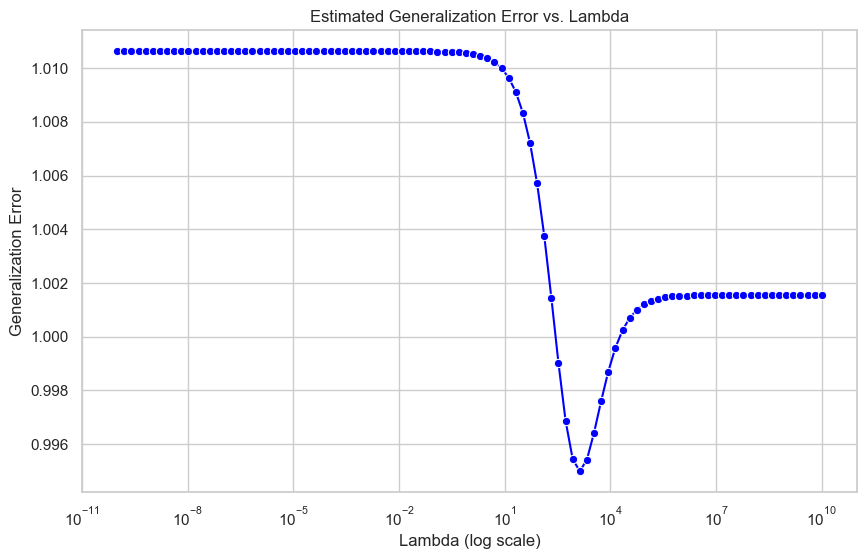

In [25]:
generalization_error = np.empty(len(lambda_interval))

for i, lambda_val in enumerate(lambda_interval):
    error_sum = 0

    for train_index, test_index in CV.split(X):
        # Extract training and test set for the current CV fold
        X_train = X[train_index, :]
        y_train = Y[train_index]
        X_test = X[test_index, :]
        y_test = Y[test_index]

        # Train Ridge regression model
        model = Ridge(alpha=lambda_val, fit_intercept=True)
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute squared error and accumulate
        error_sum += np.square(y_test - y_pred).sum() / y_test.shape[0]

    # Compute average error for this lambda value
    generalization_error[i] = error_sum / K

# Plot the estimated generalization error as a function of λ
plt.figure(figsize=(10, 6))
sns.lineplot(x=lambda_interval, y=generalization_error,
             marker='o', color='blue')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Lambda (log scale)')
plt.ylabel('Generalization Error')
plt.title('Estimated Generalization Error vs. Lambda')
plt.show()

In [26]:
best_lambda_index = np.argmin(generalization_error)
best_lambda = lambda_interval[best_lambda_index]

print(f"The lambda with the lowest generalization error: {best_lambda}")

The lambda with the lowest generalization error: 1353.0477745798075


Lambda = 10000000000.0, Average Cross-Validation Mean Squared Error: 1.0386143641366539
Test Mean Squared Error: 0.8347109583415343

Composition Features Model
Coefficients: [[ 0.00135936  0.00982811 -0.00982811 -0.02219193  0.01029426 -0.00553052
   0.01650441  0.0049523   0.00895672  0.00390043 -0.0050471   0.00077251
  -0.01016927 -0.00855207 -0.04134711 -0.00440242 -0.00605988 -0.01074603
  -0.02160811 -0.01994934 -0.04032181]]
Intercept: [0.00921611]


bpm: [ 0.00135936  0.00982811 -0.00982811 -0.02219193  0.01029426 -0.00553052
  0.01650441  0.0049523   0.00895672  0.00390043 -0.0050471   0.00077251
 -0.01016927 -0.00855207 -0.04134711 -0.00440242 -0.00605988 -0.01074603
 -0.02160811 -0.01994934 -0.04032181]


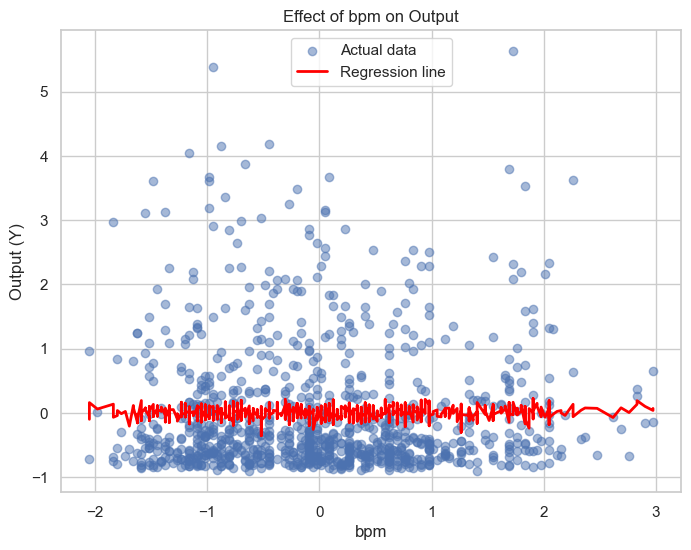

In [27]:
best_lambda_index = np.argmin(generalization_error)
best_lambda = lambda_interval[best_lambda_index]

model = Ridge(alpha=best_lambda)

    # Perform 10-fold cross-validation and compute mean squared error for each fold
cv_scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

    # Calculate the average cross-validation score
avg_mse = np.mean(-cv_scores)

print(
        f'Lambda = {lambda_val}, Average Cross-Validation Mean Squared Error: {avg_mse}')

# Train the model on the entire training set
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model on the test set
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test Mean Squared Error: {test_mse}\n')
print('Composition Features Model')
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('\n')

# Assuming model is your trained linear regression model
coefficients = model.coef_

# Print coefficients and corresponding attribute names
for feature, coef in zip(composition_features, coefficients):
    print(f"{feature}: {coef}")
    feature_index = composition_features.index(feature)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, feature_index], Y, alpha=0.5, label='Actual data')

    # Sort the feature values for better visualization of the regression line
    sorted_indices = np.argsort(X[:, feature_index])

    # Plot the regression line
    plt.plot(X[sorted_indices, feature_index], model.predict(
        X[sorted_indices, :]), color='red', label='Regression line', linewidth=2)

    plt.xlabel(feature)
    plt.ylabel('Output (Y)')
    plt.title(f'Effect of {feature} on Output')
    plt.legend()
    plt.show()


In [28]:

class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

input_size = X.shape[1] 
model = LinearRegression(input_size=input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 1000
max_gradient_norm = 5.0

for epoch in range(num_epochs):
    outputs = model(X)
    loss = criterion(outputs, Y)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

predicted = model(X).detach().numpy()

Epoch [100/1000], Loss: 0.9677
Epoch [200/1000], Loss: 0.9594
Epoch [300/1000], Loss: 0.9587
Epoch [400/1000], Loss: 0.9585
Epoch [500/1000], Loss: 0.9584
Epoch [600/1000], Loss: 0.9584
Epoch [700/1000], Loss: 0.9584
Epoch [800/1000], Loss: 0.9583
Epoch [900/1000], Loss: 0.9583
Epoch [1000/1000], Loss: 0.9583


In [29]:
# Classification

# Classify songs based on chart performance, `hit` songs on specific threshold
# Let's define the `hit` threshold
# Percentile analysis
# You could define a hit as songs that fall within the top 10% of stream counts in your dataset.
threshold = np.percentile(data["streams"], 80)
data_numeric["hit"] = (data_numeric["streams"] >= threshold).astype(int)

# Note:
# Lyrical Content (this requires scrapping)

In [30]:
# Classification - Baseline

# Classify songs based on chart performance, `hit` songs on specific threshold
# Let's define the `hit` threshold
# Percentile analysis
# You could define a hit as songs that fall within the top 10% of stream counts in your dataset.
hit_threshold = data_numeric["streams"].quantile(0.9)

data_numeric['hit'] = data['streams'].apply(
    lambda x: 1 if x > threshold else 0)


bl_X = data_numeric[composition_features]
bl_y = data_numeric['hit']

# Split the dataset into training and testing sets
bl_X_train, bl_X_test, bl_y_train, bl_y_test = train_test_split(
    bl_X, bl_y, test_size=0.2, random_state=42)

# Create a Dummy Classifier as the baseline
baseline_model = DummyClassifier(strategy='most_frequent')

# Train the baseline model
baseline_model.fit(bl_X_train, bl_y_train)

# Make predictions
baseline_predictions = baseline_model.predict(bl_X_test)

# Evaluate the baseline model
accuracy = accuracy_score(bl_y_test, baseline_predictions)
precision = precision_score(bl_y_test, baseline_predictions, zero_division=1)
recall = recall_score(bl_y_test, baseline_predictions)
f1 = f1_score(bl_y_test, baseline_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8220
Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000


In [31]:
# No this doesn't make sense

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print(f"Average Cross-Validation Accuracy: {cv_scores.mean():.2f}")

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy:.2f}")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Cross-Validation Scores: [0.78431373 0.80263158 0.77631579 0.78289474 0.76973684]
Average Cross-Validation Accuracy: 0.78
Test Set Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       157
           1       0.00      0.00      0.00        34

    accuracy                           0.82       191
   macro avg       0.41      0.50      0.45       191
weighted avg       0.67      0.82      0.74       191



-----------------------------------------------------#HENI CODE- ----------------------------------------------

In [32]:
data['populartity'] = data['streams'].apply(lambda x: 1 if x > threshold else 0)
myClassNames = ['Not Popular', 'Popular']
y = data['populartity']
X = data[composition_features]
X.head()

,bpm,mode_Major,mode_Minor,key_A,key_A#,key_B,key_C#,key_D,key_D#,key_E,...,key_F#,key_G,key_G#,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,125,1,0,0,0,1,0,0,0,0,...,0,0,0,80,89,83,31,0,8,4
1,92,1,0,0,0,0,1,0,0,0,...,0,0,0,71,61,74,7,0,10,4
2,138,1,0,0,0,0,0,0,0,0,...,0,0,0,51,32,53,17,0,31,6
3,170,1,0,1,0,0,0,0,0,0,...,0,0,0,55,58,72,11,0,11,15
4,144,0,1,1,0,0,0,0,0,0,...,0,0,0,65,23,80,14,63,11,6


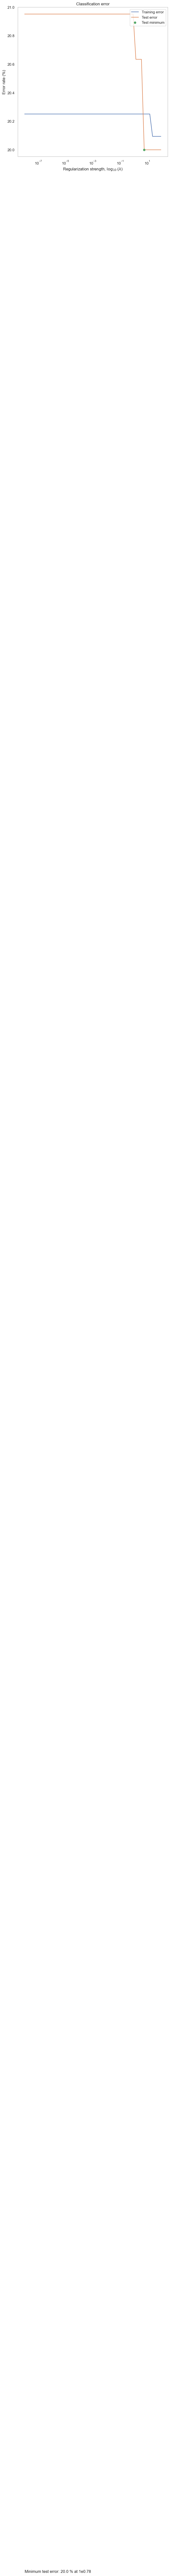

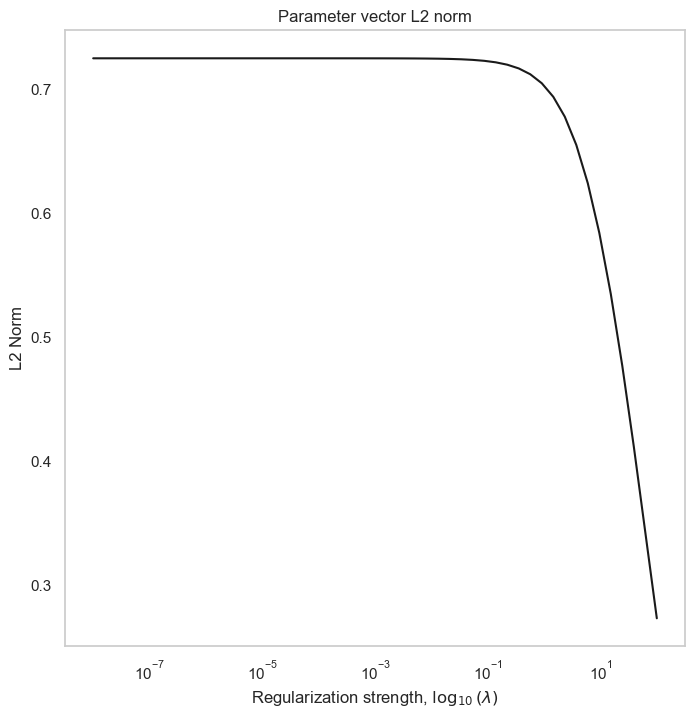

In [33]:
scaler = StandardScaler()

# Create crossvalidation partition for evaluation
K = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Fit regularized logistic regression model to training data to predict 
# the type of wine
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C = 1/lambda_interval[k] )
    
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train)
    y_test_est = mdl.predict(X_test)
    
    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0] 
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
plt.text(1e-8, 3, "Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.grid()
plt.show()    

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()    

In [35]:
from torch.utils.data import TensorDataset, DataLoader, random_split
# Set parameters
K1 = 10
K2 = 5
lambda_interval = np.logspace(-3, 2, 20)
L = 20
L_list = np.arange(1,L+1,1)

CV1 = StratifiedKFold(n_splits = K1, shuffle = True, random_state = 1)
CV2 = KFold(n_splits = K2, shuffle = True, random_state = 1)

error1_logistic = np.zeros((K1))
error2_logistic =  np.zeros((K2,len(lambda_interval)))
min_error_logistic = np.zeros(K1)
opt_lambda = np.zeros(K1)

error1_KNN = np.zeros((K1))
error2_KNN = np.zeros((K2,L))
x_KNN = [0] * K1

error_baseline = np.zeros((K1))

yhat = []
y_true = []
n = 0

# This is a simple ANN
# In total, the network is composed of two layers: one hidden layer (self.fc1 + ReLU) and one output layer (self.fc2).

#hiddem layer
class SimpleANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_unit_size=64):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_unit_size)
        self.fc2 = nn.Linear(hidden_unit_size, output_size)
        print('H_i: ', hidden_unit_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

# Number of epochs
num_epochs = 100
# For classification, it is recommended to use CrossEntropyLoss
criterion = nn.BCELoss() 

def train(model, criterion, optimizer, num_epochs, train_loader, valid_loader, patience=25):
    model.train()
    train_losses = []
    valid_losses = []
    total_acc = 0
    best_valid_loss = np.inf  # Initialize with a high value
    patience_counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()  
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        
        total_valid_loss = 0
        model.eval() 

        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                acc = (outputs.round() == targets).float().mean()
                loss = criterion(outputs, targets)
                total_valid_loss += loss.item() * inputs.size(0)
                total_acc += acc
        
        epoch_train_loss = total_train_loss / len(train_loader.dataset)
        epoch_valid_loss = total_valid_loss / len(valid_loader.dataset)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        if epoch%10==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}")

        # Check for early stopping
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break
    avg_acc = total_acc/num_epochs
    return model, avg_acc, best_valid_loss
    
for i, (train_index1, test_index1) in enumerate(CV1.split(X, y)):
    X_train1 = X.iloc[train_index1,:]
    y_train1 = y[train_index1]
    X_test1 = X.iloc[test_index1,:]
    y_test1 = y[test_index1]
    
    
    X_tensor = torch.tensor(X_train1.values, dtype=torch.float32)
    Y_tensor = torch.tensor(y_train1.values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_tensor, Y_tensor)
    train_loader = DataLoader(train_dataset, shuffle=True)
    
    X_test_tensor = torch.tensor(X_test1.values, dtype=torch.float32)
    Y_test_tensor = torch.tensor(y_test1.values, dtype=torch.float32).view(-1, 1)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = DataLoader(test_dataset, shuffle=True)
    
    input_size = X_tensor.shape[1] 
    output_size = Y_tensor.shape[1] 
    print(output_size)
    simpleANN = SimpleANN(input_size, output_size)
    optimizer = torch.optim.Adam(simpleANN.parameters(), lr=0.0001) 
    print(f"K-fold number: {i}")
    trained_model, avg_acc, loss = train(simpleANN, criterion, optimizer, num_epochs, train_loader, test_loader)
    print('Avg acc:', avg_acc)
    print('Avg error:', 100 - avg_acc)
        
    #Logistical Regression
    min_error_logistic[n] = np.min(error2_logistic.mean(0))
    opt_lambda_idx = np.argmin(error2_logistic.mean(0))
    opt_lambda[n] = lambda_interval[opt_lambda_idx]
    
    mdl = LogisticRegression(penalty='l2',multi_class='ovr', solver='liblinear', C=1/lambda_interval[n] )
    mdl.fit(X_train1, y_train1)
    y_est_log1 = mdl.predict(X_test1).T
            
    error1_logistic[n] = np.sum(y_est_log1 !=y_test1)/len(y_test1)
    
    #KNN
   # min_idx = np.argmin(error2_KNN.mean(0))
   # x_KNN[n] = L_list[min_idx]
    
   # knclassifier = KNeighborsClassifier(n_neighbors=x_KNN[n]);
   # knclassifier.fit(X_train1, y_train1);
   # y_est_KNN1 = knclassifier.predict(X_test1);
   # error1_KNN[n] = np.sum(y_est_KNN1 != y_test1) / len(y_test1)
    
    #Baseline
    baseline = np.argmax(np.bincount(y_train1))
    y_est_base = np.ones((y_test1.shape[0]), dtype = int)*baseline
    error_baseline[n] = np.sum(y_est_base != y_test1) / len(y_test1)
    
    dy = []
    dy.append(y_est_base)
    dy.append(loss)
    dy.append(y_est_log1)
    #dy = np.stack(dy, axis=1)
    yhat.append(dy)
    
    y_true.append(y_test1)
    n+=1
    

1
H_i:  64
K-fold number: 0
Epoch [1/100], Training Loss: 1.9690, Validation Loss: 2.3757
Epoch [11/100], Training Loss: 0.5075, Validation Loss: 0.5019
Epoch [21/100], Training Loss: 0.4894, Validation Loss: 0.5685
Epoch [31/100], Training Loss: 0.4835, Validation Loss: 0.5074
Epoch [41/100], Training Loss: 0.4793, Validation Loss: 0.5128
Early stopping triggered. No improvement for 25 epochs.
Avg acc: tensor(35.0700)
Avg error: tensor(64.9300)
1
H_i:  64
K-fold number: 1
Epoch [1/100], Training Loss: 1.6393, Validation Loss: 0.9170
Epoch [11/100], Training Loss: 0.5379, Validation Loss: 0.5434
Epoch [21/100], Training Loss: 0.4946, Validation Loss: 0.4802
Epoch [31/100], Training Loss: 0.4843, Validation Loss: 0.4880
Early stopping triggered. No improvement for 25 epochs.
Avg acc: tensor(24.3100)
Avg error: tensor(75.6900)
1
H_i:  64
K-fold number: 2
Epoch [1/100], Training Loss: 1.6258, Validation Loss: 0.8197
Epoch [11/100], Training Loss: 0.5275, Validation Loss: 0.5906
Epoch [21/

In [36]:
print('Error LR:\tErrors baseline')
for m in range(K1):   
    print(' ',np.round(error1_logistic[m],2),'\t\t',np.round(error_baseline[m],2))

Error LR:	Errors baseline
  0.2 		 0.2
  0.21 		 0.21
  0.2 		 0.2
  0.2 		 0.2
  0.2 		 0.2
  0.2 		 0.2
  0.21 		 0.2
  0.2 		 0.2
  0.2 		 0.2
  0.2 		 0.2


In [37]:
print('Optimal lambda: ',np.round(opt_lambda))

Optimal lambda:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
